# <font style="color:blue">Train a Mask Detector using DarkNet YOLOv3/YOLOv4</font>
This notebook consists of the steps to train a mask detector with YOLOv3/YOLOv4. We will use DarkNet framework and YOLO v3/v4 architecture.

We use the dataset provided by the OpenCV Computer Vision 2 Course for Project 2.


# <font style="color:blue">Project Structure</font>

As show below
1. The ```train.ipynb``` notebook consists of detailed steps to train the models.
1. ```darknet``` consists of the source code to train our yolo models. This folder will be built in section 2
2. ```data``` consists of all of our dataset of both images and annotations (.txt files). Each txt files corresponding to the image share the same name (different ext)
3. ```model_configs``` consists of two folders, ```yolov3-mask``` and ```yolov4-mask```, which contains all configurations of the yolov3/4 models for training and inference. Weights are stored in the ```backup``` folder.


For inferencing,
1. ```run_inference.py``` - the python script to run inference on all input images and videos in input directory
2. ```input``` folder consists of all the images and video files to run inference on
3. ```output``` folder consists of all outputs that are produced by ```run_inference.py```. They are seperated into 2 folders, ```yolov3``` and ```yolov4```, depending on which model is used for inference.

# <font style="color:blue">Table of Content</font>
1. Link Google Drive (Optional)
2. Clone and compile darknet repository
3. Process and split data to train, test and validation
4. Download weights for convolutional backbone
5. Training configurations
6. Start training
7. Run test
8. Inference and results

Section 1-4 entails the preparation of files for training 

Section 5-6 entails training the model (skip to this section after section 1-4 is done)

Section 7 entails testing the model

Section 8 entails inference and results. (skip to this section to view results)

# <font style="color:blue">1. Link Google Drive [ Skip this step if using local machine with GPU ]</font>

Ensure notebook is running on GPU Go to Runtime -> Change runtime type -> Select hardware Accelerator as GPU.

To link drive, run the cell below and follow the 2 steps.

1. It will generate a link. Click on the link to login to your google account
1. Get the authorization code and paste it in the box under the cell.


### <font style="color:green">Uncomment the 2 cells below to link google drive</font>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
# %cd /content/drive/My\ Drive

/content/drive/My Drive


# <font style="color:blue">2. Clone and compile darknet repository </font>


In [1]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15308, done.
remote: Total 15308 (delta 0), reused 0 (delta 0), pack-reused 15308
Receiving objects: 100% (15308/15308), 13.70 MiB | 7.94 MiB/s, done.
Resolving deltas: 100% (10400/10400), done.


In [1]:
%cd darknet

/home/ubuntu/face_mask_detector/darknet


In [12]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt
%cd ..

Building. . . It might take 2-3 minutes


# <font style="color:blue">3. Process and split dataset to train, test and validation</font>

## <font style="color:blue">3.1. Download Data</font>


In [11]:
!wget "https://www.dropbox.com/s/uq0x32w70c390fb/mask_no-mask_dataset.zip?dl=1" -O OID-data.zip
!unzip 'OID-data.zip' -d 'data'

/home/ubuntu
--2021-09-29 17:09:32--  https://www.dropbox.com/s/uq0x32w70c390fb/mask_no-mask_dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
^C
Archive:  OID-data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of OID-data.zip or
        OID-data.zip.zip, and cannot find OID-data.zip.ZIP, period.


## <font style="color:blue">3.2. Prepare dataset files</font>
We need to create a txt file which contains the path to the images. These files will be used while setting up the training. 

The data is split into train:validation:test, with a ratio of 80:10:10. This will create 3 txt files stored in the model_configs/yolov3/ folder, namely data_test.txt, data_val.txt, data_train.txt

In [5]:

import random
import os
import glob
import subprocess
import sys
image_dir = "./data"
f_test = open("./model_configs/" + "yolov3_mask" + "/data_test.txt", 'w')
f_val = open("./model_configs/" + "yolov3_mask" + "/data_val.txt", 'w')
f_train = open("./model_configs/" + "yolov3_mask" + "/data_train.txt", 'w')

f_testv4 = open("./model_configs/" + "yolov4_mask" + "/data_test.txt", 'w')
f_valv4 = open("./model_configs/" + "yolov4_mask" + "/data_val.txt", 'w')
f_trainv4 = open("./model_configs/" + "yolov4_mask" + "/data_train.txt", 'w')
os.chdir("data")
all_files = (glob.glob("*.jpg") + glob.glob("*.jpeg") + glob.glob("*.png"))
print(len(all_files))
os.chdir("..")
random.shuffle(all_files)

numData = len(all_files)
trainCount=0
testCount=0
valCount=0
for idx,f in enumerate(all_files):
    if idx/numData <0.1:
        f_val.write(image_dir+'/'+f+'\n')
        f_valv4.write(image_dir+'/'+f+'\n')
        valCount+=1
    elif idx/numData < 0.20:
        f_test.write(image_dir+'/'+f+'\n')
        f_testv4.write(image_dir+'/'+f+'\n')
        testCount+=1
    else:
        f_train.write(image_dir+'/'+f+'\n')
        f_trainv4.write(image_dir+'/'+f+'\n')
        trainCount+=1

print("Total Images:", numData)
print("Train Images:", trainCount)
print("Test Images:", testCount)
print("Validation Images:", valCount)
f_train.close()
f_val.close()
f_test.close()
f_trainv4.close()
f_valv4.close()
f_testv4.close()

1355
Total Images: 1355
Train Images: 1084
Test Images: 135
Validation Images: 136


# <font style="color:blue">4. Download weights for Convolutional backbone</font>
For yolov3, run the cell below.

For yolov4, download yolov4.conv.137 from https://drive.google.com/file/d/1JKF-bdIklxOOVy-2Cr5qdvjgGpmGfcbp/view and place is in face_mask_detector/model_configs/yolov4_mask directory.

In [23]:
# Original File : https://pjreddie.com/media/files/darknet53.conv.74
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O ../model_configs/yolov3_mask/darknet53.conv.74


--2021-09-29 17:24:06--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2021-09-29 17:24:06--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4bf0d10283df8271dae3cbc9c0.dl.dropboxusercontent.com/cd/0/get/BXHpc3snDeSZmV9Ng9RNoGcBGr-Za9XZVAAgKAo6BcqWhlnyNLMNiN0zHxa8cBfRyuxmPj-8hXzzlYnvAizmmzlW8o_yeOnVmkiM0A7jDnB7ZS_EsQjjzZFytDzCgUBQeLldIbtvBpjKZA293F6xBQRT/file?dl=1# [following]
--2021-09-29 17:24:07--  https://uc4bf0d10283df8271dae3cbc9c0.dl.dropboxusercontent.com/cd/0/get/BXHpc3snDeSZmV9Ng9RNoGcBGr-Za9XZVAAgKAo6BcqWhlnyNLMNiN0zHxa8cBfRyuxmPj

# <font style="color:blue">5. Training Configuration</font>
The config files are already preset to train the mask detector of two classes.
They are namely the .names, .data, .cfg files. 

These files are stored in the face_mask_detector/model_configs/yolov3_mask directory. (yolov4_mask for yolov4 counterpart).

Here are some important files and configurations to note.

1. ```class.names``` - this file contains all the unique labels of the model. For our case, there is only 2 classes as followed:
```
Mask
No-mask
```

2. ```yolov3-mask.data``` - this file provides the number of class, training and validation directory, the class names to the model. It also provide the directory where weights are stored: the backup folder
```
classes= 2
train  = ./model_configs/yolov3_mask/data_train.txt
valid = ./model_configs/yolov3_mask/data_val.txt
names = ./model_configs/yolov3_mask/class.names
backup = ./model_configs/yolov3_mask/backup/
```
3. ```yolov3-mask-train.cfg``` - the configuration files to train our model. Below are the important parameters to note

```
batch=64 
subdivisions=16 
width=416 ## input dimensions
height=416 ## input dimensions
channels=3
momentum=0.9
decay=0.0005
angle=0 #data augmentation
saturation = 1.5 #data augmentation
exposure = 1.5 #data augmentation
hue=.1 #data augmentation

learning_rate=0.0001 #initial learning rate. After experimenting, 0.0001 is a good starting value
max_batches=5500 #maximum number of iterations
policy=steps
steps=2500,4000 #at 2500, 4000, the lr will be divided by the factor of 0.1 (the scale factor listed below)
scales=.1,.1
```

Also, to change number of classes,
1. Change all classes value in the ```[yolo]``` layer
2. Change filters in the ```[convolutional]``` layer before ```[yolo]``` layer to (5+classes)*3. (filters= 21 for our case)

4. ```yolov3-mask-test.data``` and ```yolov3-mask-test.cfg``` are config files for our testing later. They contain the same format as the .data and .cfg files above, except
    1. ```yolov3-mask-test.data``` points to data_test.txt, which contains all the directory to our test data
    2. ```batch``` and ```subdivison``` are set to 1 in ```yolov3-mask-test.cfg```





# <font style="color:blue">6. Start Training </font>
To start training, execute the following commands, specifying path to setup, config and convolutional weights file.
with the following flags:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

## <font style="color:blue">6.1. Run cell below to start training weights for yolov3</font> 


In [ ]:
!./darknet/darknet detector train ./model_configs/yolov3_mask/yolov3-mask.data ./model_configs/yolov3_mask/yolov3-mask-train.cfg ./model_configs/yolov3_mask/darknet53.conv.74 -map 2> train_log.txt

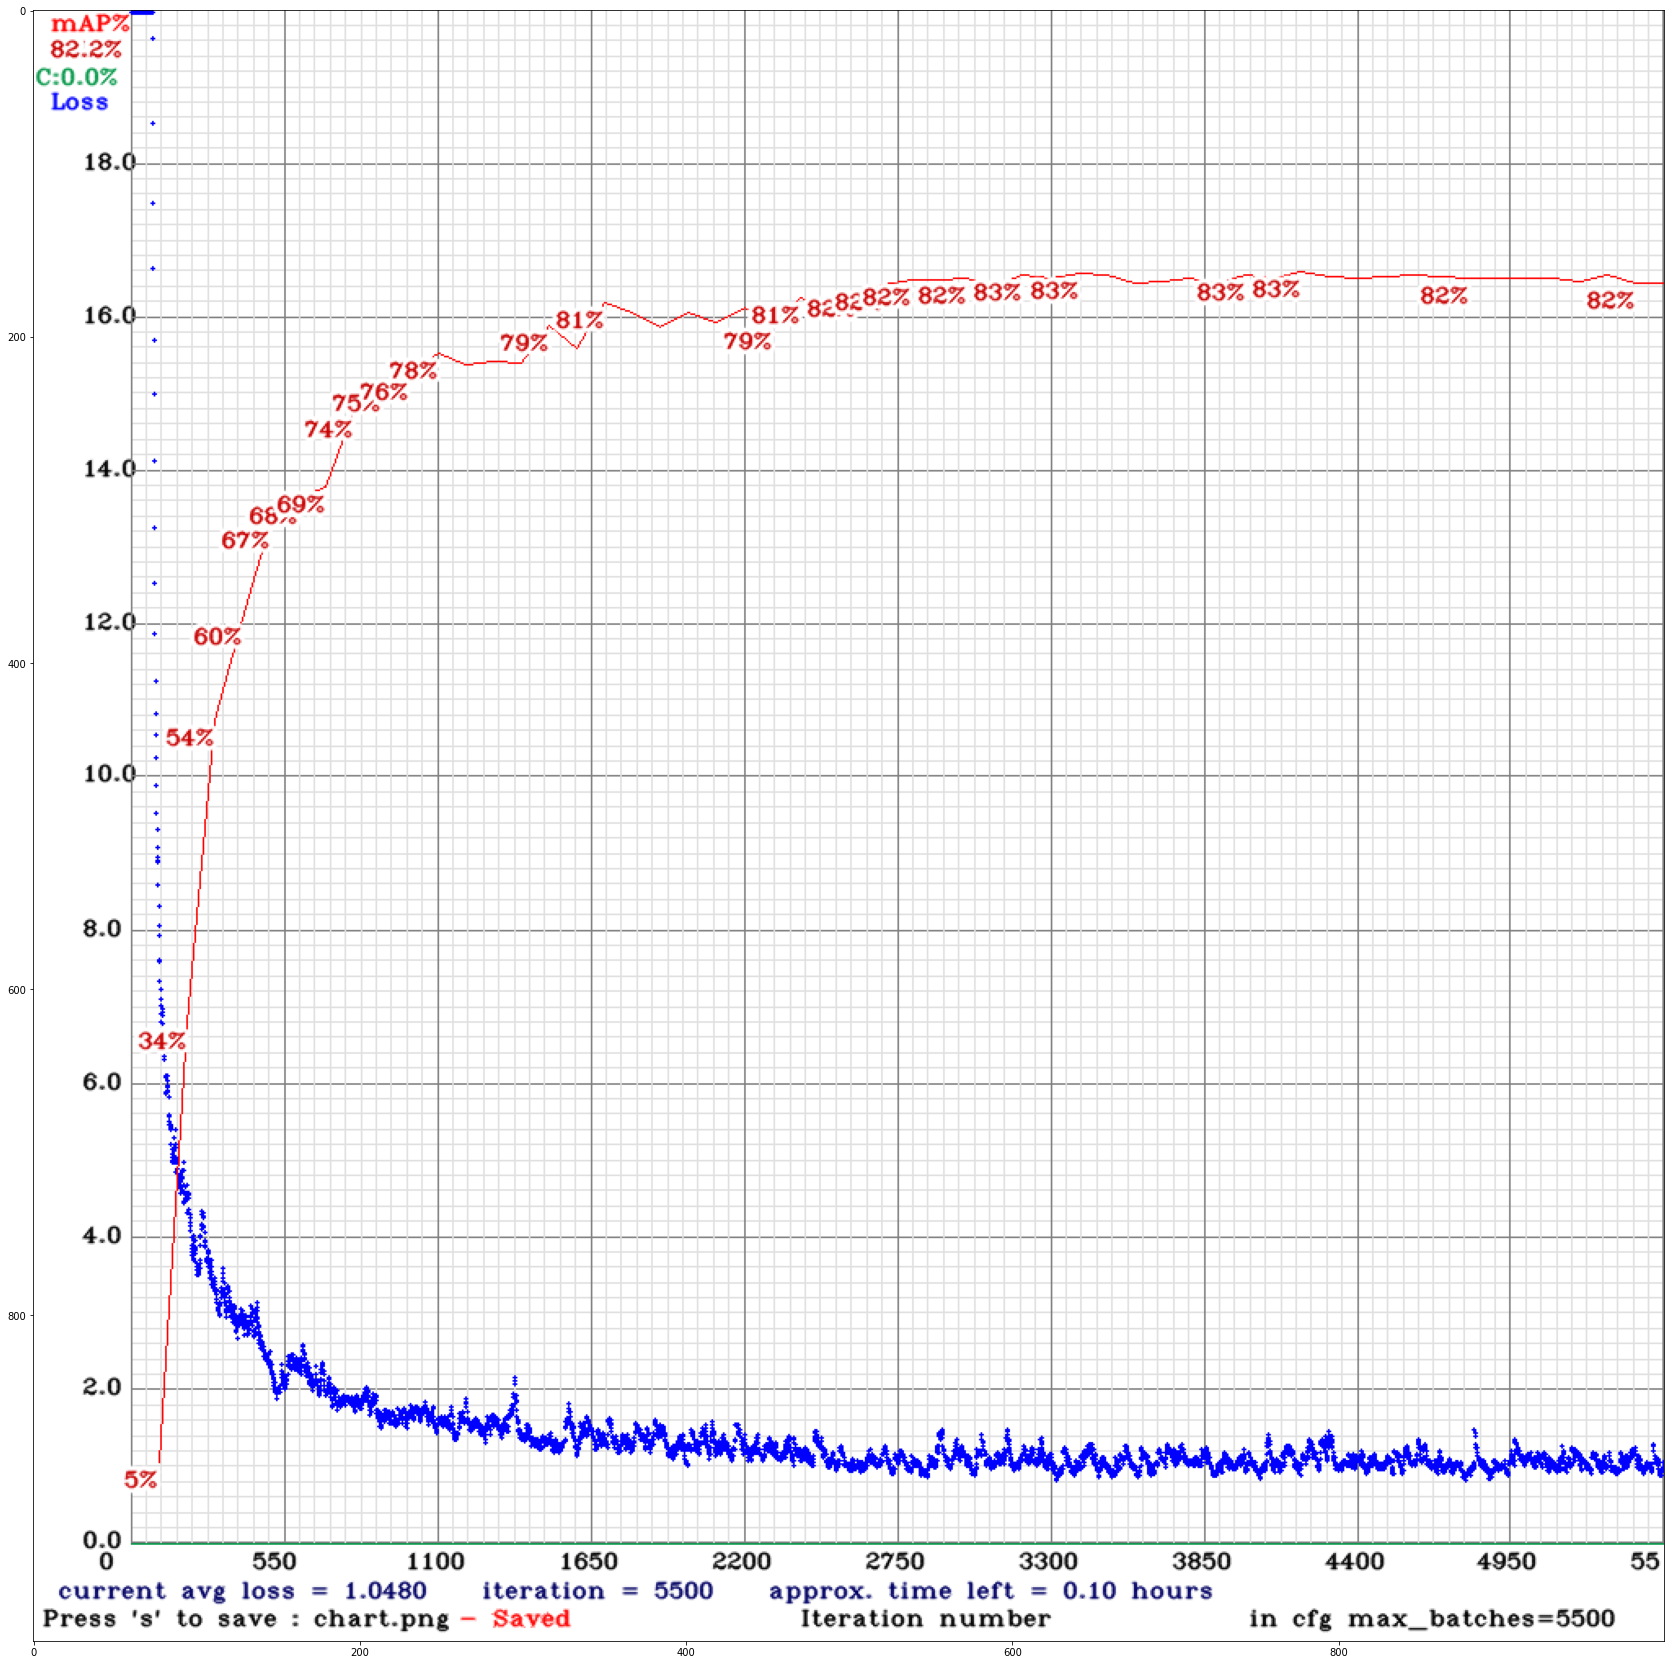

In [7]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

src = cv2.imread("chart_yolov3-mask-train.png",1)
plt.figure(figsize=[30,30])
plt.imshow(src[:,:,::-1])
plt.show()

The graph above shows my training with the yolov3 model. As you can see, the model reached a maximum mAp of 83%. The weights of best performance is also saved as ```yolov3-mask-train-best.weights```

## <font style="color:blue">6.2. Run cell below to start training weights for yolov4</font> 

In [ ]:
!./darknet/darknet detector train ./model_configs/yolov4_mask/yolov4-mask.data ./model_configs/yolov4_mask/yolov4-mask-train.cfg ./model_configs/yolov4_mask/yolov4.conv.137 -map 2> train_log.txt

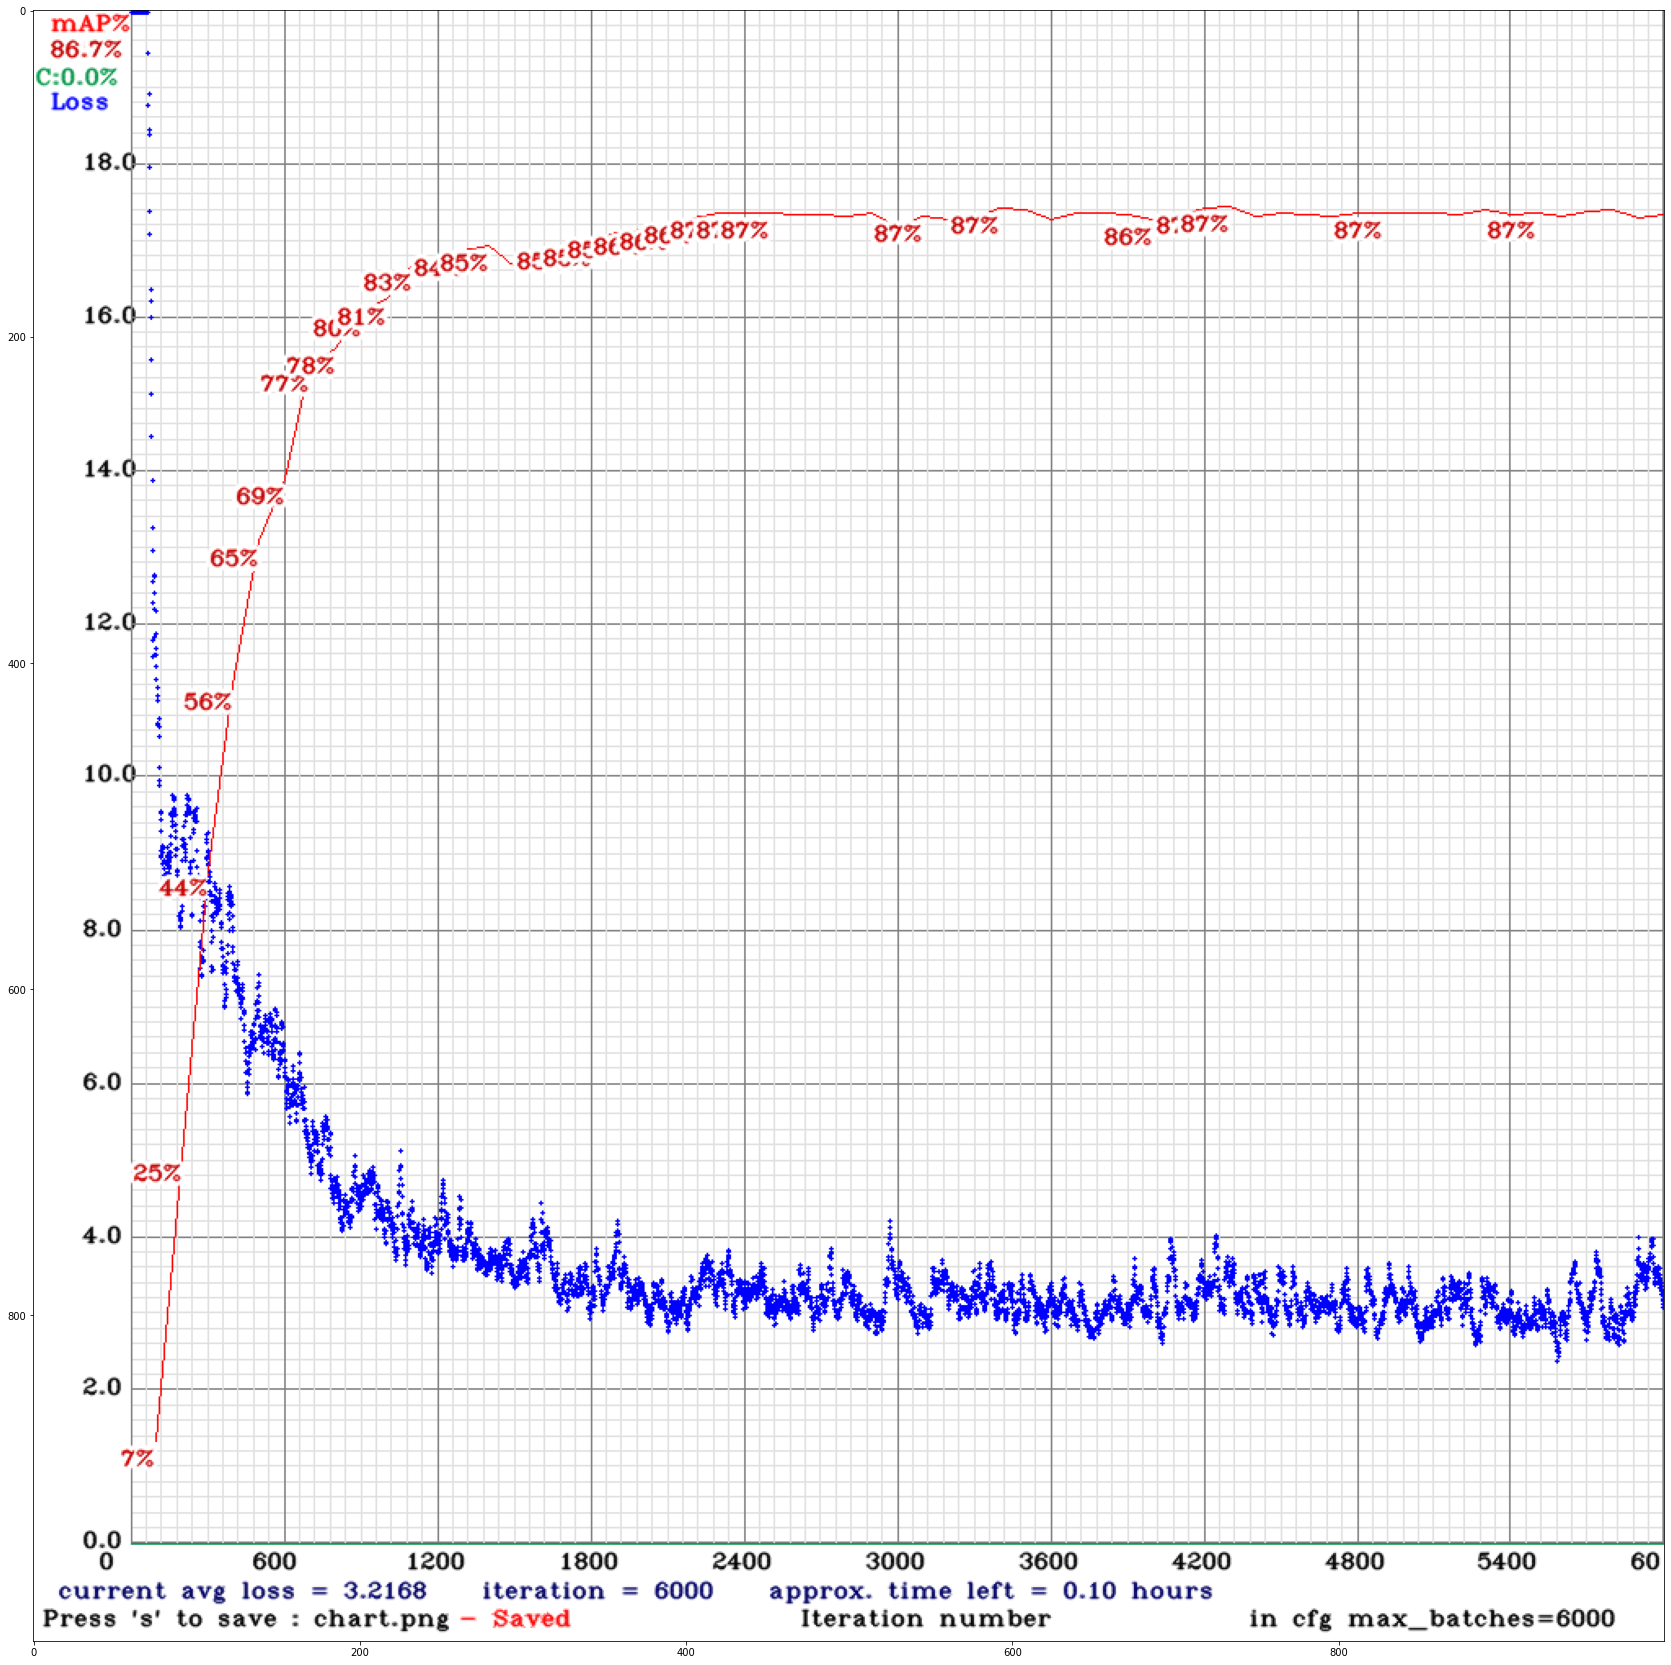

In [8]:
src = cv2.imread("chart_yolov4-mask-train.png",1)
plt.figure(figsize=[30,30])
plt.imshow(src[:,:,::-1])
plt.show()

The graph above shows my training with the yolov3 model. As you can see, the model reached a maximum mAp of 87%. The weights of best performance is also saved as ```yolov4-mask-train-best.weights```

# <font style="color:blue">7. Perform Test on test set to obtain report for mAp</font>

After training, we perform our test on the test set with the best weights we have obtained through training. Note that the batch and subdivision size must be set to 1 in the .cfg file (model_config/yolov3_mask/yolov3-mask-test.cfg). The results here will be the official results of the performance of our model.

## <font style="color:blue">7.1. Run cell below to start perform test for yolov3</font> 


In [28]:
!./darknet/darknet detector map ./model_configs/yolov3_mask/yolov3-mask-test.data ./model_configs/yolov3_mask/yolov3-mask-test.cfg ./model_configs/yolov3_mask/backup/yolov3-mask-train_final.weights -dont_show -ext_output < ./model_configs/yolov3_mask/data_test.txt  

 CUDA-version: 11000 (11000), cuDNN: 8.2.1, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: GeForce RTX 2080 Ti 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut 

 103 conv    128       1 x 1/ 1    104 x 104 x 256 ->  104 x 104 x 128 0.709 BF
 104 conv    256       3 x 3/ 1    104 x 104 x 128 ->  104 x 104 x 256 6.380 BF
 105 conv     21       1 x 1/ 1    104 x 104 x 256 ->  104 x 104 x  21 0.116 BF
 106 yolo
[yolo] params: iou loss: mse (2), iou_norm: 0.75, obj_norm: 1.00, cls_norm: 1.00, delta_norm: 1.00, scale_x_y: 1.00
Total BFLOPS 81.259 
avg_outputs = 633320 
 Allocate additional workspace_size = 38.79 MB 
Loading weights from ./model_configs/yolov3_mask/backup/yolov3-mask-train_final.weights...
 seen 64, trained: 352 K-images (5 Kilo-batches_64) 
Done! Loaded 107 layers from weights-file 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
128
 detections_count = 3270, unique_truth_count = 857  
class_id = 0, name = Mask, ap = 88.29%   	 (TP = 241, FP = 29) 
class_id = 1, name = No-mask, ap = 80.78%   	 (TP = 416, FP = 71) 

 for conf_thresh =

As shown, the reported mAp for our trained weights for yolov3 at 50% threshold is 84.54%

## <font style="color:blue">7.2. Run cell below to start perform test for yolov4</font> 


In [17]:
!./darknet/darknet detector map ./model_configs/yolov4_mask/yolov4-mask-test.data ./model_configs/yolov4_mask/yolov4-mask-test.cfg ./model_configs/yolov4_mask/backup/yolov4-mask-train_final.weights -dont_show -ext_output < ./model_configs/yolov3_mask/data_test.txt  

 CUDA-version: 11000 (11000), cuDNN: 8.2.1, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: GeForce RTX 2080 Ti 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 

 105 conv    512       1 x 1/ 1     13 x  13 x1024 ->   13 x  13 x 512 0.177 BF
 106 conv   1024       3 x 3/ 1     13 x  13 x 512 ->   13 x  13 x1024 1.595 BF
 107 conv    512       1 x 1/ 1     13 x  13 x1024 ->   13 x  13 x 512 0.177 BF
 108 max                5x 5/ 1     13 x  13 x 512 ->   13 x  13 x 512 0.002 BF
 109 route  107 		                           ->   13 x  13 x 512 
 110 max                9x 9/ 1     13 x  13 x 512 ->   13 x  13 x 512 0.007 BF
 111 route  107 		                           ->   13 x  13 x 512 
 112 max               13x13/ 1     13 x  13 x 512 ->   13 x  13 x 512 0.015 BF
 113 route  112 110 108 107 	                   ->   13 x  13 x2048 
 114 conv    512       1 x 1/ 1     13 x  13 x2048 ->   13 x  13 x 512 0.354 BF
 115 conv   1024       3 x 3/ 1     13 x  13 x 512 ->   13 x  13 x1024 1.595 BF
 116 conv    512       1 x 1/ 1     13 x  13 x1024 ->   13 x  13 x 512 0.177 BF
 117 conv    256       1 x 1/ 1     13 x  13 x 512 ->   13 x  13 x 256 0.044 BF

As shown, the reported mAp for our trained weights for yolov4 at 50% threshold is 87.55%.

# <font style="color:blue">8. Post-processing and run inference with OpenCV</font> 


Although we can run inference with the darknet source code and produce the output images and videos, I wrote a python script using OpenCV to perform inference instead. This allows us to have a better control over inference parameters such as the following

1. Preprocessing - input size

2. Postprocessing - Non-maximum suppression

3. Colors of bounding box and text

For our python script, ```run_inference.py```, the colors of mask and no-mask labels are set to green and red respectively.

The input arguments are as followed
```
("-y", "--model", type=str, default="yolov3",
	help="yolov3 or yolov4")
("-c", "--confidence", type=float, default=0.1,
	help="minimum probability to filter weak detections")
("-t", "--threshold", type=float, default=0.2,
	help="threshold when applying non-maxima suppression")
("-i", "--size_img", type=int, default=416,
	help="Input size for img (multiple of 32)")
("-v", "--size_vid", type=int, default=768,
	help="Input size for video (multiple of 32)")
```

For best performance, input size should be set to 416 since the model is trained on an input dimension of 416x416 images. However, because some of these videos contains of targets that are relatively small, increasing the input size to 768 may help to detect smaller objects.

(Note: You may run the code below to run inference. Alternatively, you may run the code from terminal to perform inference. Results will be stored in the ```output``` folder)

## <font style="color:blue">8a. Run inference with yolov3 model</font> 

In [4]:
!python3 run_inference.py --model yolov3 --confidence 0.1 --threshold 0.2 --size_img 416 --size_vid 768

Traceback (most recent call last):
  File "run_inference.py", line 135, in <module>
    net, classes, colors, output_layers = load_yolo(model_name)
  File "run_inference.py", line 32, in load_yolo
    net = cv2.dnn.readNet("./model_configs/yolov3_mask/backup/yolov3-mask-train_best.weights", "./model_configs/yolov3_mask/yolov3-mask-train.cfg")
cv2.error: OpenCV(4.5.1) /tmp/pip-req-build-n_alixql/opencv/modules/dnn/src/darknet/darknet_io.cpp:896: error: (-213:The function/feature is not implemented) Transpose the weights (except for convolutional) is not implemented in function 'ReadDarknetFromWeightsStream'



## <font style="color:blue">8b. Run inference with yolov4 model</font> 

In [2]:
!python3 run_inference.py --model yolov4 --confidence 0.1 --threshold 0.2 --size_img 416 --size_vid 768

Traceback (most recent call last):
  File "run_inference.py", line 135, in <module>
    net, classes, colors, output_layers = load_yolo(model_name)
  File "run_inference.py", line 34, in load_yolo
    net = cv2.dnn.readNet("./model_configs/yolov4_mask/backup/yolov4-mask-train_best.weights", "./model_configs/yolov4_mask/yolov4-mask-train.cfg")	
cv2.error: OpenCV(4.5.1) /tmp/pip-req-build-n_alixql/opencv/modules/dnn/src/darknet/darknet_io.cpp:896: error: (-213:The function/feature is not implemented) Transpose the weights (except for convolutional) is not implemented in function 'ReadDarknetFromWeightsStream'



## <font style="color:blue">8c. Inference results</font> 

In [ ]:
#To display output in notebook
def display_output(img_filename):
    yv3 = cv2.imread('output/yolov3/' + img_filename)
    yv4 = cv2.imread('output/yolov4/' + img_filename)

    plt.figure(figsize=[40,40])
    plt.subplot(121)
    plt.imshow(yv3[:,:,::-1])
    plt.title("Inference results of yolov3 model")
    plt.subplot(122)
    plt.imshow(yv4[:,:,::-1])
    plt.title("Inference results of yolov4 model")
    plt.show()

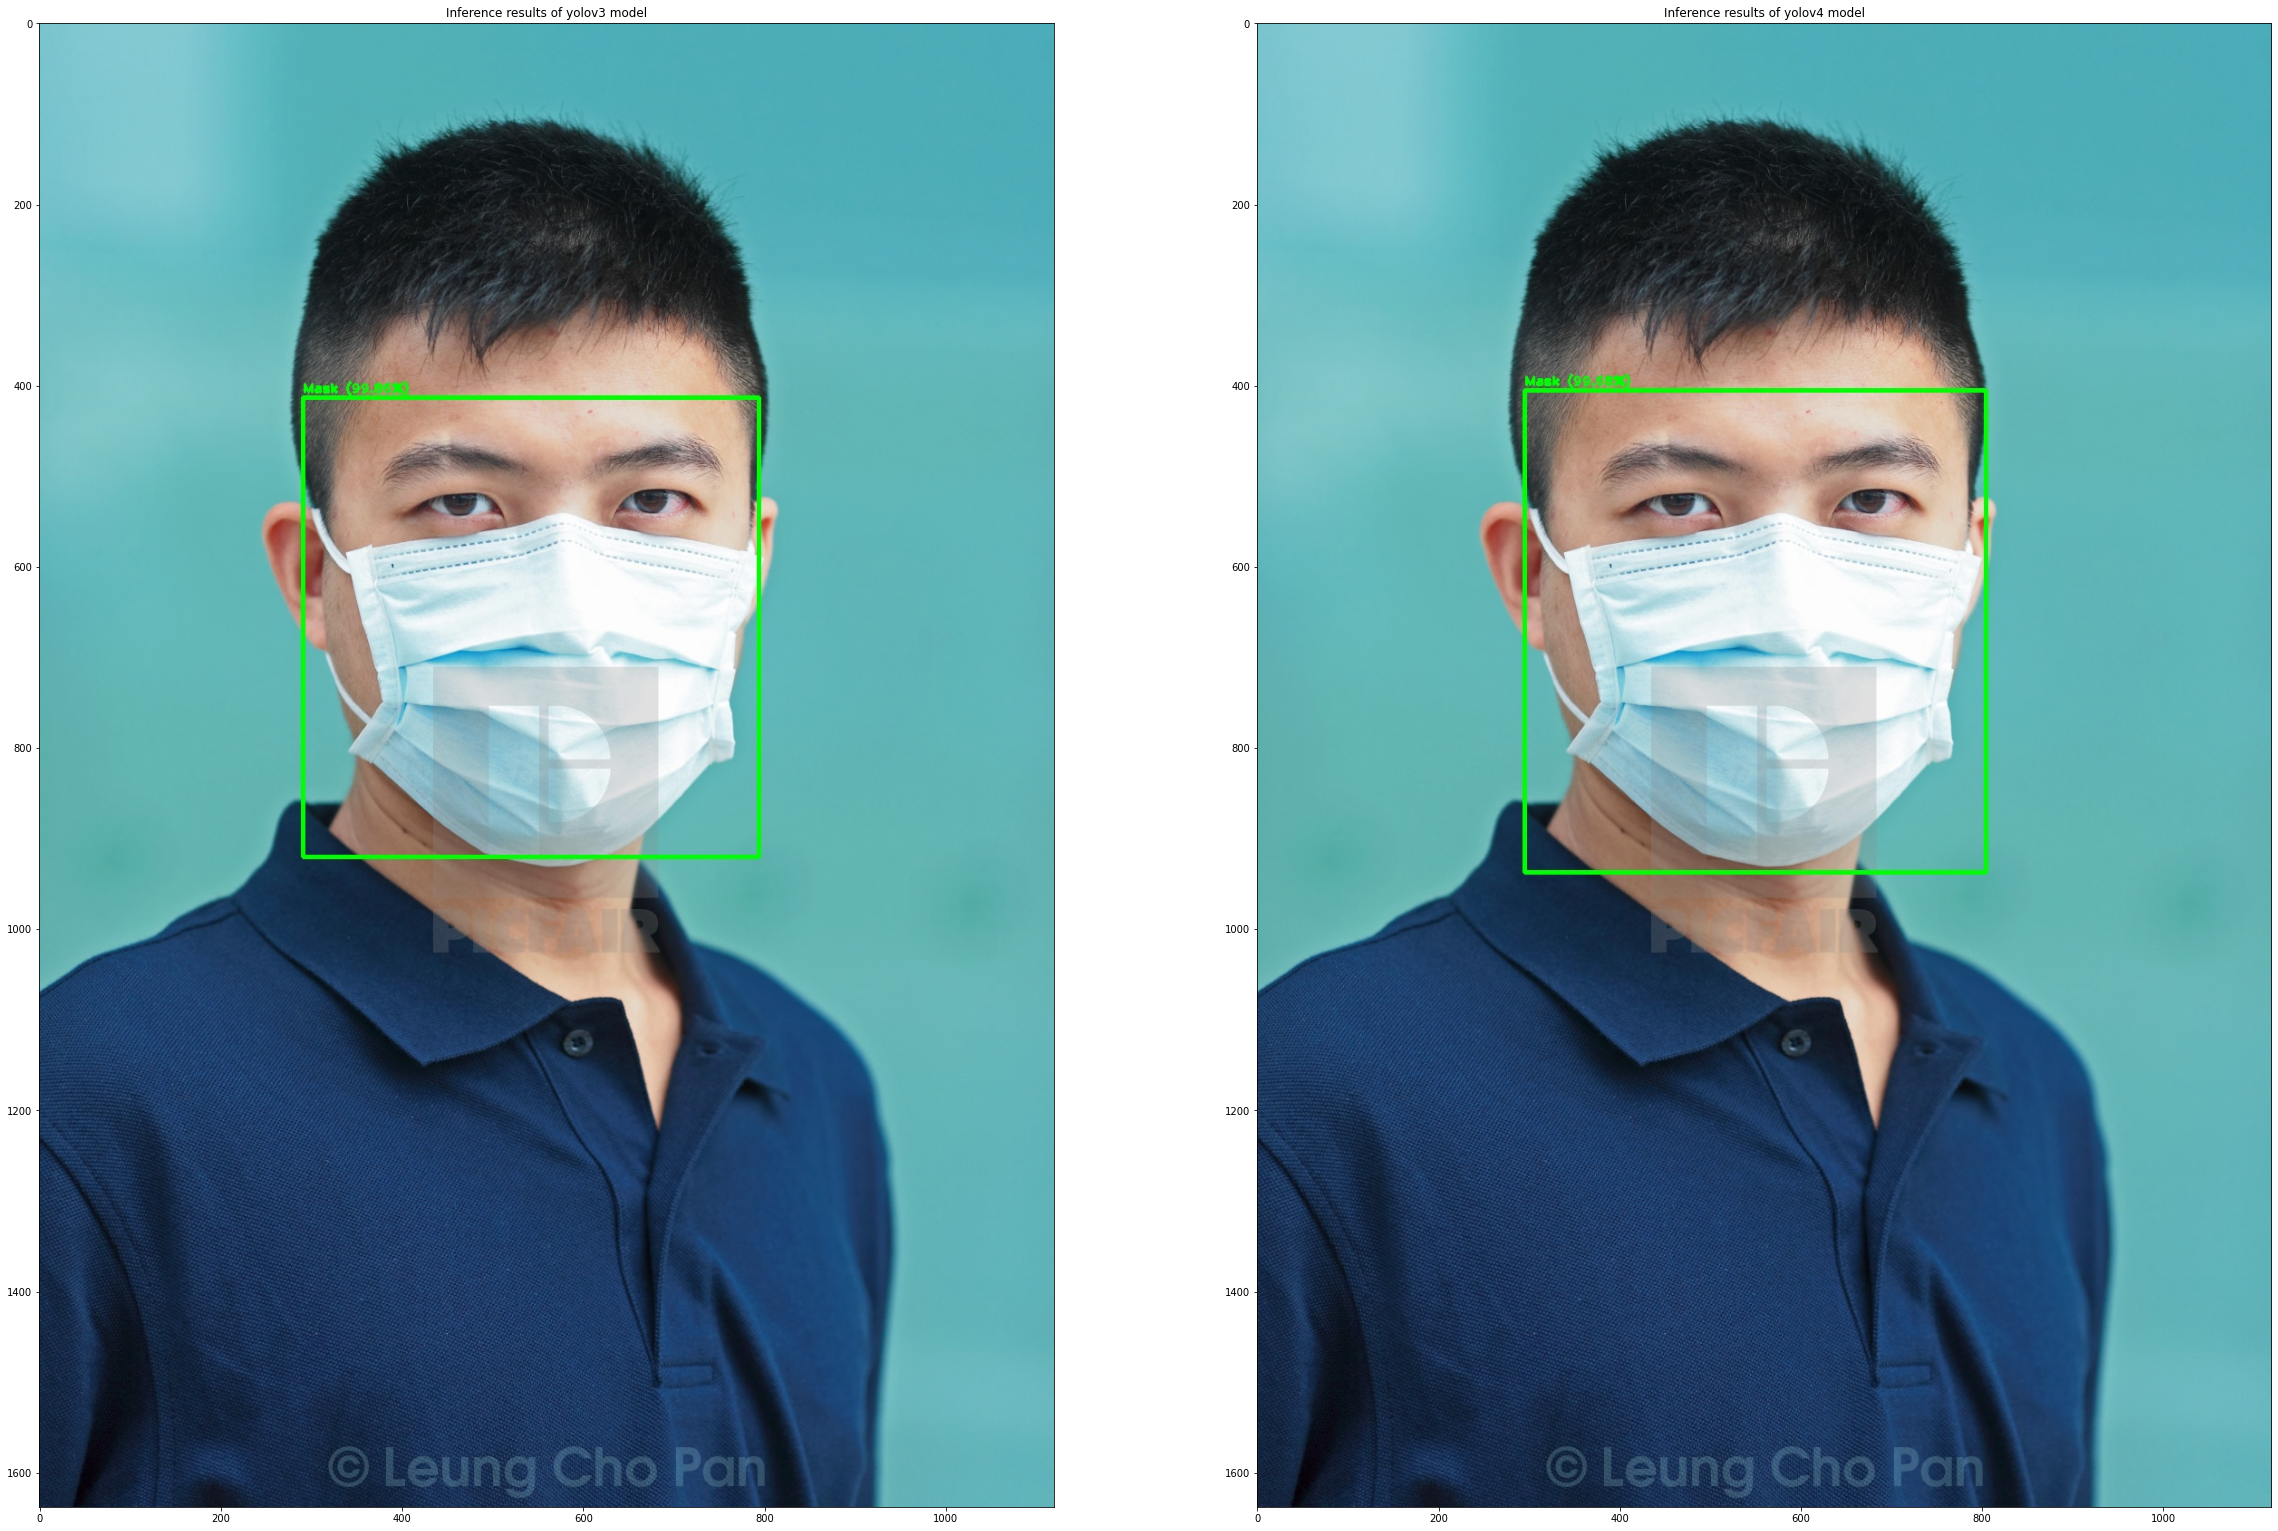

In [27]:
display_output('test-image1.jpg')

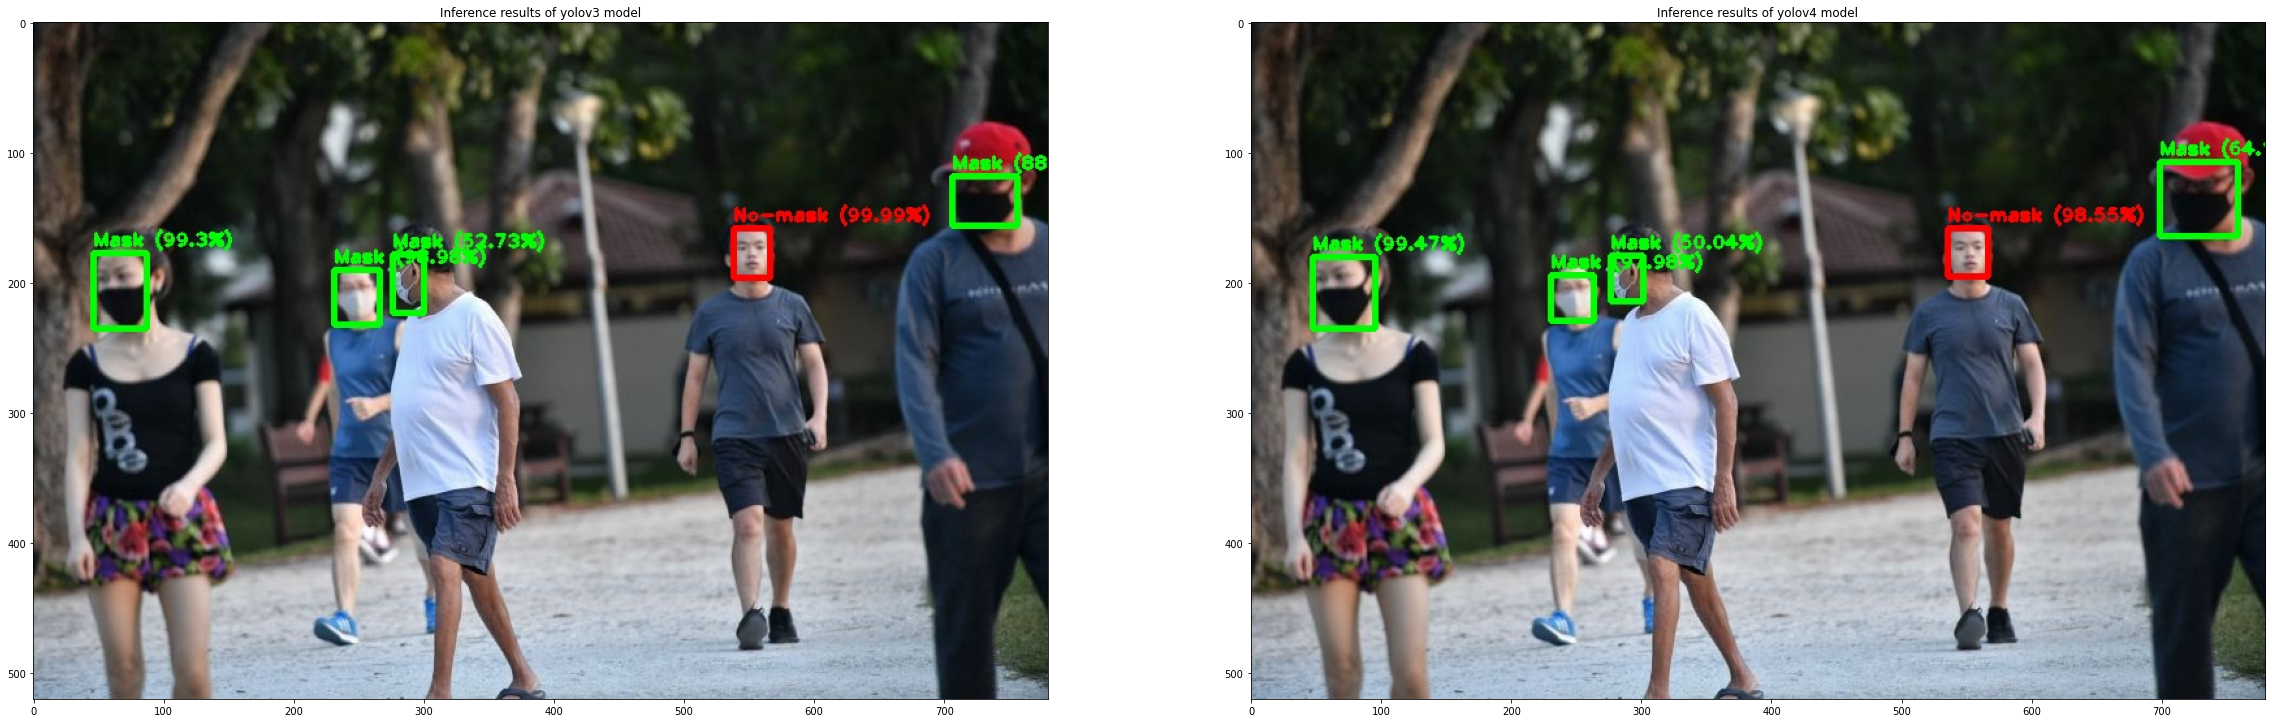

In [28]:
display_output('test-image2.jpg')

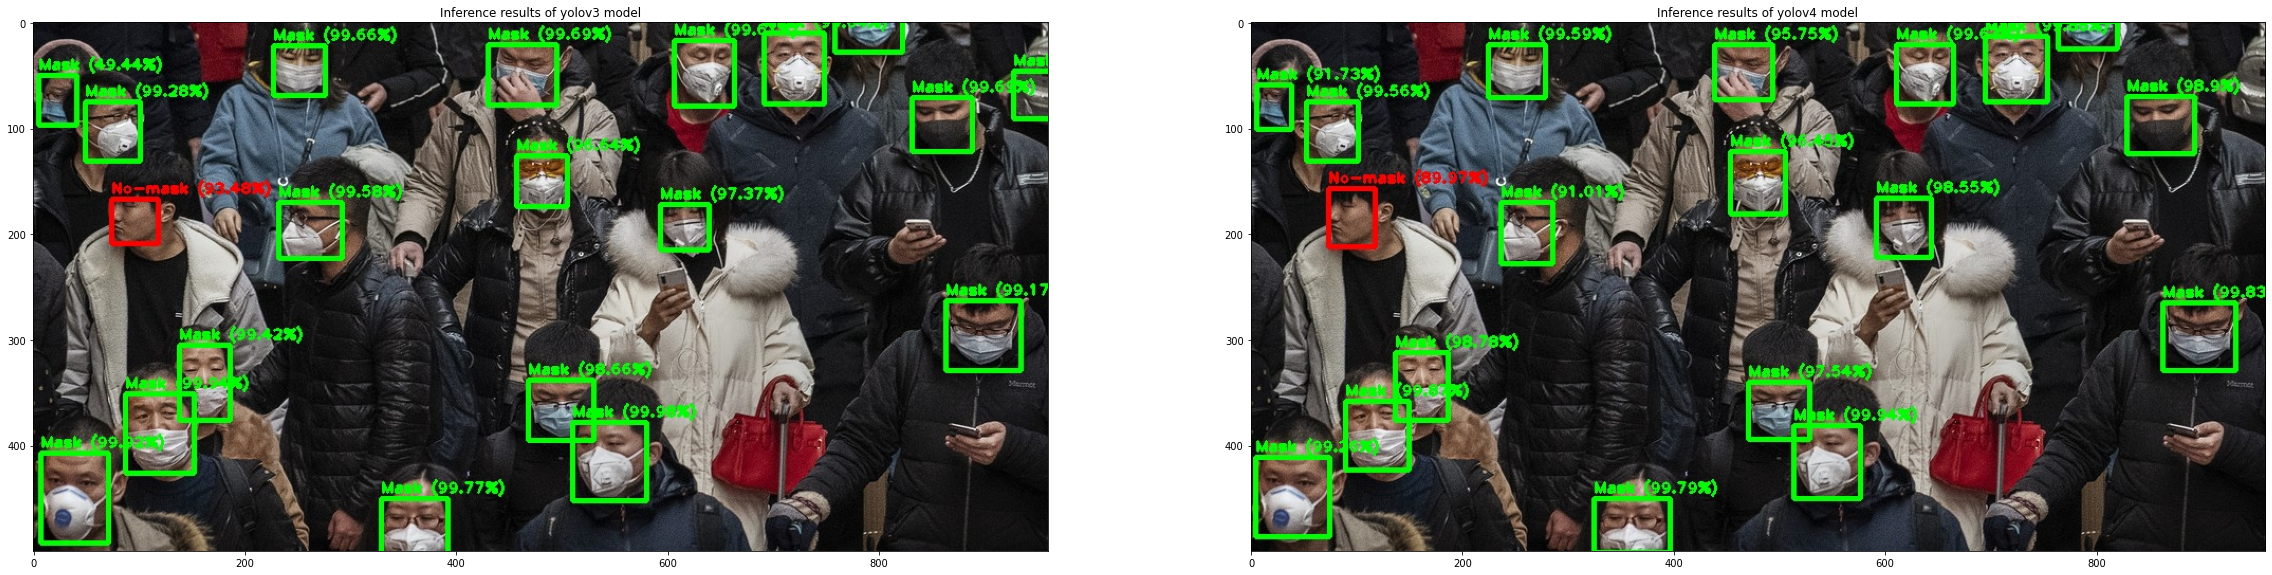

In [29]:
display_output('test-image3.jpg')

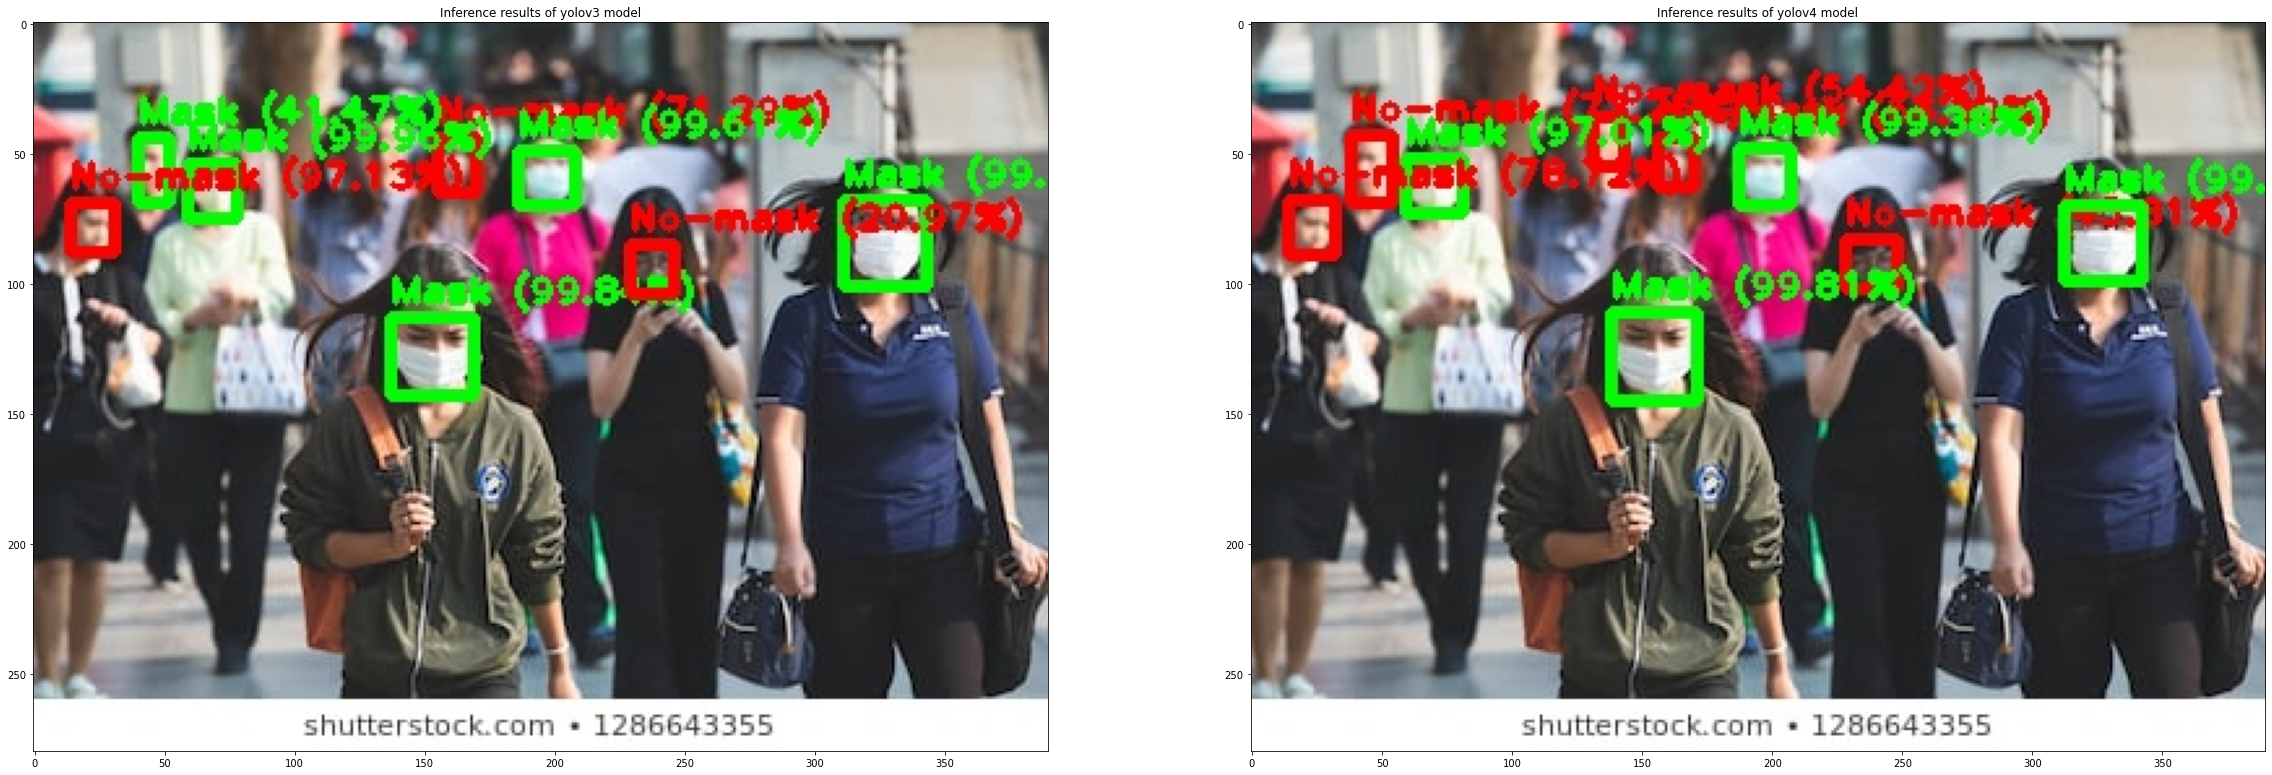

In [30]:
display_output('test-image4.jpg')